# Predictive Model for Next Month's Credit Card Delinquencies

### Problem:
Our client is a credit card company. They brought us a dataset that includes recent demographic and financial data (from the last six months) from a sample of 30,000 account holders. This data was at the credit account level. The rows are labeled according to whether, in the month following the six-month historical data period, an account holder became delinquent, i.e., did not make the minimum payment.

### Objective:
Develop a predictive model to forecast whether an account will become delinquent in the next month, using demographic and historical data.

### Data dictionary:
- ID = ID
- LIMIT_BAL: Amount of credit granted (in New Taiwan Dollars), including individual consumer and family credit.
- SEX: Gender (1 = male ; 2 = female)
- EDUCATION: Level of Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
- MARRIAGE: Marital Status (1 = married ; 2 = single ; 3 = others)
- AGE: Idade (years)
- PAY_1 - PAY_6: Records of Past Payments. Monthly payments from April to September are stored in these columns.
  - PAY_1 = Represents the September refund
  - PAY_2 = Represents the August refund
  - ...
  - PAY_6 = Represents the April refund
  - The payment scale is as follows: -2 = The account started the month with no outstanding balance, and the credit was not used; -1 = On-time payment; 0 = Minimum payment made, but the outstanding balance was not paid ; 1 = One-month payment delay; 2 = Two-month payment delay; And so on, up to 9 = Nine-month or more payment delay.
- BILL_AMT1 - BILL_AMT6: Invoice amount
  - BILL_AMT1 = Represent the September invoice amount
  - BILL_AMT2 = Represent the August invoice amount
  - ...
  - BILL_AMT6 = Represent the April invoice amount

## 1. Loading the libraries and dataset

In [73]:
# Loading the Pandas Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [74]:
# Adjust on matplotlib
mpl.rcParams['figure.dpi'] = 100

In [4]:
# Loading the dataset
df = pd.read_excel('./data/default_of_credit_card_clients__courseware_version_1_21_19.xls')

## 2. Data exploration and cleaning

In [10]:
# Checking the numbers of rows and columns
print(f"The dataframe have", df.shape[0], "rows and", df.shape[1], "columns")

The dataframe have 30000 rows and 25 columns


In [11]:
# First view
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [13]:
# Columns types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  int64 
 3   EDUCATION                   30000 non-null  int64 
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   PAY_1                       30000 non-null  object
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [15]:
# Checking for unique IDs
df['ID'].nunique()

29687

In [18]:
# Checking for duplicate values
id_counts = df['ID'].value_counts()
id_counts.value_counts()

count
1    29374
2      313
Name: count, dtype: int64

In [34]:
# Storing boolean values
dupe_mask = id_counts == 2
dupe_mask[0:5]

ID
ad23fe5c-7b09    True
1fb3e3e6-a68d    True
89f8f447-fca8    True
7c9b7473-cc2f    True
90330d02-82d9    True
Name: count, dtype: bool

In [35]:
id_counts.index[0:5]

Index(['ad23fe5c-7b09', '1fb3e3e6-a68d', '89f8f447-fca8', '7c9b7473-cc2f',
       '90330d02-82d9'],
      dtype='object', name='ID')

In [37]:
dupe_ids = id_counts.index[dupe_mask]
dupe_ids = list(dupe_ids)
len(dupe_ids)

313

In [38]:
dupe_ids[0:5]

['ad23fe5c-7b09',
 '1fb3e3e6-a68d',
 '89f8f447-fca8',
 '7c9b7473-cc2f',
 '90330d02-82d9']

In [40]:
# Looking for the first 3 duplicates IDs
df.loc[df['ID'].isin(dupe_ids[0:3]),:].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5033,89f8f447-fca8,320000,2,2,1,32,0,0,0,0,...,169371,172868,150827,8000,8000,5500,6100,6000,5000,0
5133,89f8f447-fca8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16727,1fb3e3e6-a68d,80000,1,2,2,33,2,2,0,0,...,27394,29922,31879,0,2000,2000,3000,2600,0,1
16827,1fb3e3e6-a68d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29685,ad23fe5c-7b09,50000,1,3,1,32,0,0,0,0,...,12882,8131,3983,3000,2871,1000,163,3983,3771,1
29785,ad23fe5c-7b09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Boolean df for 0
df_zero_mask = df == 0
df_zero_mask

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,True,True,True,True,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,True,False,False
2,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
29996,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,True
29997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
29998,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False


In [43]:
# Boolean serie without the first column (ID)
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
sum(feature_zero_mask)

315

In [44]:
# Cleaning the 0's in df
df_clean_1 = df.loc[~feature_zero_mask,:].copy()
df_clean_1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [45]:
df_clean_1.shape

(29685, 25)

In [46]:
# Checking the columns types
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          29685 non-null  object
 1   LIMIT_BAL                   29685 non-null  int64 
 2   SEX                         29685 non-null  int64 
 3   EDUCATION                   29685 non-null  int64 
 4   MARRIAGE                    29685 non-null  int64 
 5   AGE                         29685 non-null  int64 
 6   PAY_1                       29685 non-null  object
 7   PAY_2                       29685 non-null  int64 
 8   PAY_3                       29685 non-null  int64 
 9   PAY_4                       29685 non-null  int64 
 10  PAY_5                       29685 non-null  int64 
 11  PAY_6                       29685 non-null  int64 
 12  BILL_AMT1                   29685 non-null  int64 
 13  BILL_AMT2                   29685 non-null  int64 


In [47]:
# Checking why the column 'PAY_1' is not int64
df_clean_1['PAY_1'].value_counts()

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

'0' and 'Not available' don't exist at the data dictnary as a valid value.

In [48]:
# Removing rows with PAY_1 == 'Not available'
valid_pay_1_mask = df_clean_1['PAY_1'] != 'Not available'
sum(valid_pay_1_mask)

26664

In [49]:
# Creating a new clean dataframe
df_clean_2 = df_clean_1.loc[valid_pay_1_mask,:].copy()
df_clean_2.shape

(26664, 25)

In [50]:
# Checking the values on PAY_1
df_clean_2['PAY_2'].value_counts()

PAY_2
 0    13961
-1     5368
 2     3509
-2     3375
 3      289
 4       85
 5       24
 1       24
 7       17
 6       11
 8        1
Name: count, dtype: int64

In [51]:
# Converting the colunm 'PAY_1' to int64
df_clean_2['PAY_1'] = df_clean_2['PAY_1'].astype('int64')
df_clean_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26664 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          26664 non-null  object
 1   LIMIT_BAL                   26664 non-null  int64 
 2   SEX                         26664 non-null  int64 
 3   EDUCATION                   26664 non-null  int64 
 4   MARRIAGE                    26664 non-null  int64 
 5   AGE                         26664 non-null  int64 
 6   PAY_1                       26664 non-null  int64 
 7   PAY_2                       26664 non-null  int64 
 8   PAY_3                       26664 non-null  int64 
 9   PAY_4                       26664 non-null  int64 
 10  PAY_5                       26664 non-null  int64 
 11  PAY_6                       26664 non-null  int64 
 12  BILL_AMT1                   26664 non-null  int64 
 13  BILL_AMT2                   26664 non-null  int64 


## 3. Exploring Credit Limit and Demographic Characteristics

In [56]:
# Exploring 'LIMIT_BAL' and 'AGE'
df_clean_2[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


In [57]:
# Exploring 'EDUCATION'
df_clean_2['EDUCATION'].value_counts()

EDUCATION
2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: count, dtype: int64

The options 0, 5, and 6 don't exist in the dictionary, so we'll group them into option 0

In [62]:
# Replacing the values '0', '5' and '6' to '4'
df_clean_2['EDUCATION'].replace(to_replace=[0,5,6], value=4, inplace=True)
df_clean_2['EDUCATION'].value_counts()

C:\Users\rodrigo.junqueira\AppData\Local\Temp\ipykernel_5304\783757042.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean_2['EDUCATION'].replace(to_replace=[0,5,6], value=4, inplace=True)


EDUCATION
2    12458
1     9412
3     4380
4      414
Name: count, dtype: int64

In [63]:
# Exploring 'MARRIAGE'
df_clean_2['MARRIAGE'].value_counts()

MARRIAGE
2    14158
1    12172
3      286
0       48
Name: count, dtype: int64

In [64]:
# Replacing the value '0' to '3'
df_clean_2['MARRIAGE'].replace(to_replace=[0], value=3, inplace=True)
df_clean_2['MARRIAGE'].value_counts()

C:\Users\rodrigo.junqueira\AppData\Local\Temp\ipykernel_5304\2888951217.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean_2['MARRIAGE'].replace(to_replace=[0], value=3, inplace=True)


MARRIAGE
2    14158
1    12172
3      334
Name: count, dtype: int64

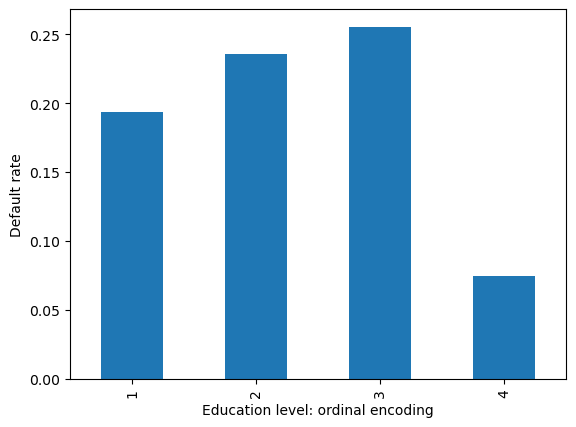

In [77]:
df_clean_2.groupby('EDUCATION').agg({'default payment next month':'mean'}).plot.bar(legend=False)
plt.ylabel('Default rate')
plt.xlabel('Education level: ordinal encoding')
plt.show()

## 4. Implementing one-hot encoding (OHE) on 'EDUCATION'

In [79]:
# Creating a new column
df_clean_2['EDUCATION_CAT'] = 'none'

In [80]:
df_clean_2[['EDUCATION', 'EDUCATION_CAT']].head(10)

,EDUCATION,EDUCATION_CAT
0,2,none
1,2,none
2,2,none
3,2,none
4,2,none
5,1,none
6,1,none
7,2,none
8,3,none
9,3,none


In [81]:
# Dictionary with the education values
cat_mapping = {
    1: "graduate school",
    2: "university",
    3: "high school",
    4: "others"
}

# Apllying the dictionary on the new column
df_clean_2['EDUCATION_CAT'] = df_clean_2['EDUCATION'].map(cat_mapping)
df_clean_2[['EDUCATION', 'EDUCATION_CAT']].head()

,EDUCATION,EDUCATION_CAT
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university


In [83]:
# Creating a new dataframe with OHE
edu_ohe = pd.get_dummies(df_clean_2['EDUCATION_CAT'], dtype=int)
edu_ohe.head(10)

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,1,0,0,0
6,1,0,0,0
7,0,0,0,1
8,0,1,0,0
9,0,1,0,0


In [85]:
# concating the ohe dataframe
df_with_ohe = pd.concat([df_clean_2, edu_ohe], axis=1)
df_with_ohe[['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']].head(10)

,EDUCATION_CAT,graduate school,high school,others,university
0,university,0,0,0,1
1,university,0,0,0,1
2,university,0,0,0,1
3,university,0,0,0,1
4,university,0,0,0,1
5,graduate school,1,0,0,0
6,graduate school,1,0,0,0
7,university,0,0,0,1
8,high school,0,1,0,0
9,high school,0,1,0,0


In [88]:
# Checkpoint
df_with_ohe.to_csv('./data/cleaned_data_ohe.csv', index=False)